# Model of alcohol consumption in high school students

This section of the analysis will attempt to construct a model to predict:

* Walc - level of workday alcohol consumption
* Dalc - level of weekend alcohol consumption
* binge_drinker - a high level (4-5) of weekend alcohol consumption accompanied by a low level (1-2) of weekday alcohol consumption.
* heavy_drinker - a higher level (4-5) of weekend alcohol consumption accompanied by a high level (4-5) of weekday alcohol consumption.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
%matplotlib inline 
#to allow plots to render in the notebook

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

# Reading in file and checking columns

In [53]:
data = pd.read_csv('../input/student_math_por_formatted.csv')
print(data.shape)
print(data.columns)

(1044, 51)
Index(['Unnamed: 0', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
       'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3', 'subject', 'Mjob_at_home', 'Mjob_health',
       'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_course', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_father', 'guardian_mother', 'guardian_other', 'binge_drinker',
       'heavy_drinker', 'overall_grade'],
      dtype='object')


# Modelling
## Predicting Walc / Dalc

In [55]:
#moving the alcohol related variables to the end of the feature list.
cols = data.columns[1:] #to get rid of "unnamed: 0" column
cols = cols.tolist()
Walc_Dalc = cols[22:24]
heavy_binge = cols[-3:-1]
school_to_goout = cols[:22]
health_to_guardian_other =cols[24:-3]
overall_grade = [cols[-1]]
cols = school_to_goout + health_to_guardian_other + overall_grade + heavy_binge + Walc_Dalc
data = data[cols]
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'G3', 'subject',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'overall_grade', 'binge_drinker',
       'heavy_drinker', 'Dalc', 'Walc'],
      dtype='object')

In [78]:

Dalc_X = data.iloc[:, :-4]
Dalc_y = data.iloc[:, -2:-1].values.reshape(-1,)

X_train, X_test, y_train, y_test = train_test_split(Dalc_X, Dalc_y, random_state=0)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, PowerTransformernsformer

estimators = [('robust_scaler', RobustScaler()), 
              ('reduce_dim', PCA()), 
              ('normalise_pca', PowerTransformer()), #I applied this as the distribution of the PCA factors were skew
              ('clf', LinearDiscriminantAnalysis())]

print(X_train.shape)

pipe = Pipeline(estimators)
pipe.fit(X_train, y_train)

param_grid = dict(reduce_dim__n_components=[None, 2, 5, 10])
grid_search = GridSearchCV(pipe, param_grid=param_grid)
grid_search.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
#print(grid_search.best_estimator_.steps[-1][1].coef_)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
print(grid_search.score(X_test, y_test))


(783, 46)


C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[[161  12   2   3   1]
 [ 35   7   5   1   0]
 [ 16   2   4   0   0]
 [  3   1   4   0   0]
 [  1   1   1   0   1]]
0.726692209451
0.662835249042
0.685823754789


C:\Users\Joey\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Since the EDA suggested a mixture of linear and non-linear relationships, I will use the VarianceThreshold to select features.

The first pass, with threshold 0.0, did not eliminate any features. Since the size of the dataset seems to be problematic, I will try to shrink the dimensionality of the prediction problem with an aggressive 0.95 threshold.

In [57]:
pca_estimator = grid_search.best_estimator_.steps[1][1]
pca_df = pd.DataFrame(data=pca_estimator.components_, columns=X_train.columns)
pca_df = pca_df.transpose()
pca_df.columns = ["PCA1", "PCA2"]

def get_n_largest_features(component_name, n):
    #trying to return the top n components with a placing
    abs_col = str(component_name + "_abs")
    pca_df[abs_col] = pca_df[component_name].abs()
    components = pca_df.nlargest(n, abs_col)[[component_name, abs_col]]
    df = pd.DataFrame(data=components).reset_index()
    df["rank"] = df[abs_col].rank(ascending=False)
    df = df.loc[:, ["index", component_name, "rank"]]
    df.columns=["feature_name", "variance_explained", "rank"]
    return df



#I want a list of the top n features (name, variance_explained) for each components
pca1 = get_n_largest_features("PCA1", 10)
pca2 = get_n_largest_features("PCA2", 10)
pca_df = pd.merge(pca1, pca2, on="rank", suffixes=("_PCA1", "_PCA2"))
pca_df = pca_df.set_index("rank")
pca_df
#pca_df.rank()

#this comes in later
#pca_df["explained_variance"] = pca_estimator.explained_variance_

#PCA1 looks like it might be '(lack of) academic application'
#PCA2 looks like it might be 'pressure'

,feature_name_PCA1,variance_explained_PCA1,feature_name_PCA2,variance_explained_PCA2
rank,,,,
1.0,G3,-0.560277,freetime,-0.682149
2.0,G2,-0.470097,absences,0.517113
3.0,overall_grade,-0.465954,famrel,-0.444434
4.0,G1,-0.389652,goout,-0.140356
5.0,failures,0.170762,sex,-0.099798
6.0,studytime,-0.115829,reason_course,-0.085451
7.0,traveltime,0.089033,studytime,0.082110
8.0,Medu,-0.085786,activities,-0.072328
9.0,Fedu,-0.070719,reason_home,0.064152


In [58]:
power_trans = grid_search.best_estimator_.steps[2][1]
power_trans = power_trans.transform(pca_results)

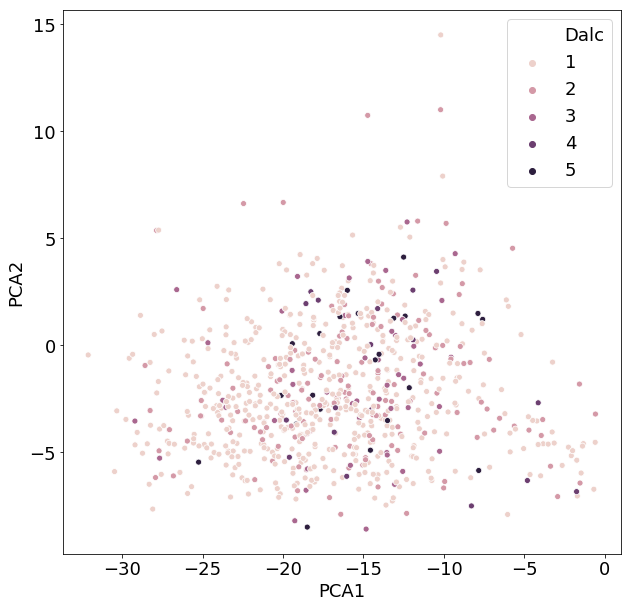

In [73]:
pca_results = grid_search.best_estimator_.steps[1][1]
pca_results = pca_results.transform(X_train)
pca_results = pd.DataFrame(data=pca_results)
pca_results.columns = ["PCA1", "PCA2"]
#sns.scatterplot("PCA1", "PCA2", data=pca_results);

power_trans = grid_search.best_estimator_.steps[2][1]
power_trans = power_trans.transform(pca_results)
power_trans = pd.DataFrame(data=power_trans)
power_trans.columns = ["PCA1", "PCA2"]
power_trans["Dalc"] = y_train
f, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.scatterplot("PCA1", "PCA2", hue="Dalc", data=power_trans, legend="full"); 
#if I use the default param for legend, Seaborn will create a weird legend with the following values (0, 1, 3, 4, 6)


In [ ]:
#sns.catplot("Dalc", data=power_trans)
sns.countplot("Dalc", data=power_trans)

In [ ]:
clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
clf.classes_

In [ ]:
sns.distplot(power_trans["PCA1"])

In [ ]:
sns.distplot(power_trans["PCA2"])

In [ ]:
pca_results = grid_search.best_estimator_.steps[3][1]
pca_results.classes_

In [ ]:
#find the components being passed to LDA

In [ ]:
from sklearn.feature_selection import VarianceThreshold

#note, even though subject is excluded by the method, 
#it should not be removed as it will artificially increase the class count
#that is, some of these rows are the same student but for different subjects. 
#See the EDA for more information on reluctance to merge

selector = VarianceThreshold(0.95) #possible dataleakage here

net_data = data.iloc[:, :-4] #subsetting the data
targets = data.iloc[:, -4:]
selector.fit_transform(net_data) #performing variance threshold on the subset
mask = selector.get_support() #getting the boolean mask
new_cols = [["subject"], net_data.columns[mask], targets]
new_cols = [item for items in new_cols for item in items]
net_data = data[new_cols]
net_data.columns

In the EDA previous, Walc and Dalc were highly correlated. Thus, to answer a more interesting hypothesis than "Does weekend alcohol consumption predict weekday alcohol consumption and vice versa", I will drop the alcohol consumption variables from the input variable set.

The following method is to setup the learning curve testing harness.

In [ ]:
#train_sizes = [0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 0.99]
train_sizes = np.linspace(0.5, 0.9, num=9)

gross_Walc = {
    "name" : "gross_Walc",
    "X" : data.iloc[:, :-4], #index of -4 to pull all variables directly related with alcohol out of the feature set
    "y" : data.iloc[:, -1:].values.reshape(-1,)
}
net_Walc = {
    "name" : "net_Walc",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -1:].values.reshape(-1,)
}    
gross_Dalc = {
    "name" : "gross_Dalc",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:, -2:-1].values.reshape(-1,)
}
net_Dalc = {
    "name" : "net_Dalc",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -2:-1].values.reshape(-1,)
} 


net_and_gross_data = [gross_Dalc, net_Dalc, gross_Walc, net_Walc]

#haven't hooked this up yet. Trying to work out how to pass in the metric to be used.
def score_model(model, metric):
    
    score_train = eval(model + "." + metric + "(X_train, y_train)")
    score_test = model.metric(X_test, y_test)

    return {"score_train" : score_train, "score_test" : score_test }

def plot_learning_curve(method, train_sizes, datasets):
    
    test_and_train_performance = pd.DataFrame(columns=["train_size", "train_score", "test_score", "dataset", "dataset_scope", "target"])
    for dataset in net_and_gross_data:
        data = [method(train_size, dataset["X"], dataset["y"]) for train_size in train_sizes]
        data = pd.DataFrame(data=data, columns=["train_size", "train_score", "test_score"])
        data["dataset"] = dataset["name"]
        data["dataset_scope"] = data["dataset"].str.extractall(r'(\w{3,5})_').iloc[:, 0].values
        data["target"] = data["dataset"].str.extractall(r'_(\w{4})').iloc[:, 0].values
        
        test_and_train_performance = pd.concat([test_and_train_performance, data])
        
    def generate_point_plots(target, set_name):

        fig, axes = plt.subplots(1,2, sharey=True, figsize=(28, 12))
        fig.suptitle(str("Learning Curve (accuracy): " + set_name))
        
        curve_data = test_and_train_performance.loc[test_and_train_performance["target"] == target, :]
        ax1 = axes[0] 
        ax2 = axes[1]
        sns.pointplot("train_size", "train_score", hue="dataset_scope", data=curve_data, ax=ax1)
        ax1.set_title("train score")
        sns.pointplot("train_size", "test_score", hue="dataset_scope", data=curve_data, ax=ax2)
        ax2.set_title("test score")
        ax2.set_ylabel("")
        ax1.set_ylabel("score")

    
    #names = [item["name"] for item in net_and_gross_data]
    generate_point_plots("Dalc","Weekend Alcohol Consumption (\"Dalc\")")
    generate_point_plots("Walc","Weekday Alcohol Consumption (\"Walc\")")

    
    test_score = test_and_train_performance["test_score"].groupby(
        [test_and_train_performance["target"], test_and_train_performance["dataset_scope"]]
    ).mean()
    print("Mean test score across training set size")
    print(pd.DataFrame(data=test_score))
    
    return test_and_train_performance

## Obtaining Baseline: Stratified Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier

def check_dummy_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    nbclf = DummyClassifier(strategy="most_frequent", random_state=0).fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = nbclf.score(X_train, y_train)
    score_test = nbclf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_dummy_learning_curve, train_sizes, net_and_gross_data);

You may be wondering where the "gross" line is. It has been perfectly superimposed by the "net" line (because the stratified dummy classifier predicts the test class targets consistent with the frequency of the training values independent of the features in either set).

The dummy classifier has set a baseline against which the other models can be evaluated:
* Weekend Drinking (Dalc): 0.68
* Weekday Drinking (Walc): 0.36

### Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB

def check_nbclassifier_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    nbclf = GaussianNB().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = nbclf.score(X_train, y_train)
    score_test = nbclf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_nbclassifier_learning_curve, train_sizes, net_and_gross_data);

Out of the box, 
* the low performance on the train and test scores suggest underfitting on this model.
* the performance is even lower than the dummy classifier, perhaps due to the violation of the independence assumption.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_randomforest_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = RandomForestClassifier().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_randomforest_learning_curve, train_sizes, net_and_gross_data);

0.71 Walc, 0.49 on Dalc

The test score patterns suggest that more data will greatly increase the strength of this model.

However, with random forest models, interpretability suffers. So, while we may have a model that could strongly predict whether a student is at risk of heavy drinking, it is difficult for us to communicate why we believe a student is at risk

### Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_lda_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_lda_learning_curve, train_sizes, net_and_gross_data);

Both on the gross sets
0.68
0.48

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#even there are a few lines of repeated code here, it felt more sensible to keep it in case I want to change params on the classifier
def check_qda_learning_curve(train_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)

    clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    
    #just accuracy to start off, but should change to roc_auc
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
#plot_learning_curve(check_qda_learning_curve, train_sizes, net_and_gross_data);0

It seems the feature needs to be massaged a little to work with Quadratic. It might only need a little pca.

Could just throw up a plot to give the reasons why the model isn't compatible with the data:
* collinearity
* has only 1 sample in class 1

###  KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve

def check_knn_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    knn = KNeighborsClassifier().fit(X, y)

    score_train = knn.score(X_train, y_train)
    score_test = knn.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_knn_learning_curve, train_sizes, net_and_gross_data);

0.74
0.57

Unfortunately, the only conclusion that can be made is that the models are unstable with increasing training data size. This points to the dataset as being too small for these models to be effective.
## Predicting binge_drinker, heavy_drinker


In [ ]:
from sklearn.linear_model import LogisticRegression

gross_binge_drinker = {
    "name" : "gross_binge_dinker",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:,-4:-3].values.reshape(-1,)
}
net_binge_drinker = {
    "name" : "net_binge_drinker",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:,-4:-3].values.reshape(-1,)
}    
gross_heavy_drinker = {
    "name" : "gross_heavy_drinker",
    "X" : data.iloc[:, :-4], 
    "y" : data.iloc[:, -3:-2].values.reshape(-1,)
}
net_heavy_drinker = {
    "name" : "net_heavy_drinker",
    "X" : net_data.iloc[:, :-4],
    "y" : net_data.iloc[:, -3:-2].values.reshape(-1,)
} 

binge_and_heavy_drinking_patterns = [gross_binge_drinker, net_binge_drinker, gross_heavy_drinker, net_heavy_drinker]

### Get baseline: Stratified Dummy Classifier

In [ ]:
def check_dummy_drinking_pattern_learning_curve(train_size, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = DummyClassifier(random_state=0).fit(X, y)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)

plot_learning_curve(check_dummy_drinking_pattern_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);
#the first graph shows performance for detecting heavy drinking
#the second graph shows performance for detecting binge drinking

Heavy drinking - 0.53
Binge drinking - 0.21

### Logistic Regression

In [ ]:
def check_logit_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = LogisticRegression().fit(X, y)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_logit_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);


* Heavy 0.72
* Binge 0.49

In [ ]:
def check_lda_drinking_habits_learning_curve(train_size, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=train_size)
    
    clf = LinearDiscriminantAnalysis().fit(X, y)
    print(clf.classes_)

    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)

    return(train_size, score_train, score_test)
    
    
plot_learning_curve(check_lda_drinking_habits_learning_curve, train_sizes, binge_and_heavy_drinking_patterns);0

Heavy - 0.73
Binge - 0.48